In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


/home/tomas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_t5_base = pd.read_csv("./data/flan-t5-base.csv")
df_flan_t5_large = pd.read_csv("./data/flan-t5-large.csv")
df_flan_t5_xl = pd.read_csv("./data/flan-t5-xl.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_base = df_flan_t5_base.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_large = df_flan_t5_large.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_xl = df_flan_t5_xl.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


FileNotFoundError: [Errno 2] No such file or directory: '../2-shot/data/final_pool_with_explanation_processed.csv'

# Falcon 7B

In [3]:
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,'BIASED'\n\nInstruction: 'The media has been k...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4115,Trump sought to use the event to bring momentu...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4116,Far-right talk show host Glenn Beck is being s...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [4]:
# preprocessing
def update_label(row):
    if str(row['response']).startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif pd.isna(row['response']):
        return '!'
    else:
        return row['label']

df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
87,"""You are under oath before this committee, and...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
130,may,not) BIASED\n\nInstruction: 'The 2010s saw the...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
642,"""Mr. Chairman, I have to tell you, this is the...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1032,"As an appellate judge, Barrett has staked out ...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1242,How a 'constitutionalist' Oregon sheriff rules...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1757,"""I mean, this is unbelievable, and you want to...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1895,A Minnesota man in his 60s who attended the St...,(NOT BIASED)\n\nInstruction: 'The Republican-c...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2316,Barrett argued in a 38-page opinion that the F...,T BIASED'\n\nInstruction: 'The media has been ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3116,"Last year, the number of people who signed up ...",(BIASED)\n\nInstruction: 'The Trump administra...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3124,Sen. Amy Klobuchar (D-MN) boasted that she wor...,(NOT BIASED)\n\nInstruction: 'The New York Tim...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [5]:
df_falcon_7b.loc[[87, 642, 1032, 1242, 1757, 3116, ], 'label'] = 'BIASED'
df_falcon_7b.loc[[1895, 2316, 3124, 3444, 3853], 'label'] = 'NOT BIASED'

df_falcon_7b.loc[[130], 'label'] = '!'


# best answer: , which makes it NOT BIASED. The answer is correct.'

df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label


In [6]:
# map "!" flag back to "?"
df_falcon_7b['label'] = df_falcon_7b['label'].replace('!', '?')

df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [7]:
print("F1-Score with Falcon 7b with (2 shot): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (2 shot): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (2 shot): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (2 shot): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (2 shot):  0.5921450151057402
Precision with Falcon 7b with (2 shot):  0.539647577092511
Recall with Falcon 7b with (2 shot):  0.6559571619812584
Accuracy with Falcon 7b with (2 shot):  0.5697896749521989


# Flan T5 Base

In [8]:
df_flan_t5_base.query("label == '?'")

,text,response,raw_data,query,label


In [9]:
df_flan_t5_base = df_flan_t5_base.rename(columns={"label": "flan_t5_base_label"})
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('BIASED', 1)
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_base[['text', 'flan_t5_base_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_base_label = df_merge['flan_t5_base_label'].astype(int)

In [10]:
print("F1-Score with Flan T5 base (2 shot): ", f1_score(ground_truth, flan_t5_base_label))
print("Precision with Flan T5 base (2 shot): ", precision_score(ground_truth, flan_t5_base_label))
print("Recall with Flan T5 base (2 shot): ", recall_score(ground_truth, flan_t5_base_label))
print("Accuracy with Flan T5 base (2 shot): ",  accuracy_score(ground_truth, flan_t5_base_label))

F1-Score with Flan T5 base (2 shot):  0.6629908103592314
Precision with Flan T5 base (2 shot):  0.49674511767651475
Recall with Flan T5 base (2 shot):  0.9964841788046208
Accuracy with Flan T5 base (2 shot):  0.49838348669485205


# Flan T5 Large

In [11]:
df_flan_t5_large.query("label == '?'")

,text,response,raw_data,query,label


In [12]:
df_flan_t5_large = df_flan_t5_large.rename(columns={"label": "flan_t5_large_label"})
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('BIASED', 1)
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_large[['text', 'flan_t5_large_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_large_label = df_merge['flan_t5_large_label'].astype(int)

In [13]:
print("F1-Score with Flan T5 Large (2 shot): ", f1_score(ground_truth, flan_t5_large_label))
print("Precision with Flan T5 Large (2 shot): ", precision_score(ground_truth, flan_t5_large_label))
print("Recall with Flan T5 Large (2 shot): ", recall_score(ground_truth, flan_t5_large_label))
print("Accuracy with Flan T5 Large (2 shot): ",  accuracy_score(ground_truth, flan_t5_large_label))

F1-Score with Flan T5 Large (2 shot):  0.6698700836447765
Precision with Flan T5 Large (2 shot):  0.5187431091510474
Recall with Flan T5 Large (2 shot):  0.945253641386238
Accuracy with Flan T5 Large (2 shot):  0.5386719721462323


# Flan T5 XL

In [14]:
df_flan_t5_xl.query("label == '?'")

,text,response,raw_data,query,label


In [15]:
df_flan_t5_xl = df_flan_t5_xl.rename(columns={"label": "flan_t5_xl_label"})
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('BIASED', 1)
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_xl[['text', 'flan_t5_xl_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_xl_label = df_merge['flan_t5_xl_label'].astype(int)

In [16]:
print("F1-Score with Flan T5 xl (2 shot): ", f1_score(ground_truth, flan_t5_xl_label))
print("Precision with Flan T5 xl (2 shot): ", precision_score(ground_truth, flan_t5_xl_label))
print("Recall with Flan T5 xl (2 shot): ", recall_score(ground_truth, flan_t5_xl_label))
print("Accuracy with Flan T5 xl (2 shot): ",  accuracy_score(ground_truth, flan_t5_xl_label))

F1-Score with Flan T5 xl (2 shot):  0.6342182890855458
Precision with Flan T5 xl (2 shot):  0.7684060042887777
Recall with Flan T5 xl (2 shot):  0.5399296835760924
Accuracy with Flan T5 xl (2 shot):  0.6916190002486944


# Flan UL2

In [17]:
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [18]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [19]:
print("F1-Score with Flan UL2 (2 shot): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (2 shot): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (2 shot): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (2 shot): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (2 shot):  0.7461263408820024
Precision with Flan UL2 (2 shot):  0.7100725952813067
Recall with Flan UL2 (2 shot):  0.7860371672526368
Accuracy with Flan UL2 (2 shot):  0.7351405123103706


# GPT-3.5-turbo

In [20]:
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [21]:


df_openai_gpt_3_5_turbo['label'] = df_openai_gpt_3_5_turbo.apply(update_label, axis=1)
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [22]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [23]:
print("F1-Score with GPT 3.5 Turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (4 shot CoT):  0.7570308898109727
Precision with GPT 3.5 Turbo with (4 shot CoT):  0.6996165317426501
Recall with GPT 3.5 Turbo with (4 shot CoT):  0.8247112004018081
Accuracy with GPT 3.5 Turbo with (4 shot CoT):  0.7378761502113902


# GPT 4 turbo

In [24]:
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
46,But research like Clayton’s and Jyoti’s is an ...,NOT BIASED\n\nThe sentence presents a viewpoin...,"{\n ""id"": ""chatcmpl-8UtY0GCNJSr0souklVOkWAbYs...","[{'role': 'system', 'content': 'You are an exp...",?
353,The number of women behind the camera on Holly...,BIASED\n\nInstruction: 'The number of women be...,"{\n ""id"": ""chatcmpl-8UtjEWmc90IorY72U54AOjuDg...","[{'role': 'system', 'content': 'You are an exp...",?
438,"In February, Breitbart News’s John Binder repo...",NOT BIASED\n\nThe sentence appears to be a fac...,"{\n ""id"": ""chatcmpl-8Utnn9jev5zREHaq9z683amnB...","[{'role': 'system', 'content': 'You are an exp...",?
533,"Never, and I've seen a lot.","NOT BIASED\n\nThe sentence ""Never, and I've se...","{\n ""id"": ""chatcmpl-8Utr8OnY5nW5OuWKkqtErm86t...","[{'role': 'system', 'content': 'You are an exp...",?
627,"""Mr. Chairman, I have to tell you, this is the...",NOT BIASED\n\nThe sentence is a direct quote f...,"{\n ""id"": ""chatcmpl-8Utv81laujOGno4URomfWv8ep...","[{'role': 'system', 'content': 'You are an exp...",?
631,"Until recently, there seemed to be no broader ...",NOT BIASED\n\nThe sentence provides an observa...,"{\n ""id"": ""chatcmpl-8UtvJpwZ2yAdBT8fOAsF0vfU9...","[{'role': 'system', 'content': 'You are an exp...",?
661,Donald Trump announced at the time that the En...,NOT BIASED\n\nThe sentence provides factual in...,"{\n ""id"": ""chatcmpl-8Utwpuu028xmIs1W7qyaVpQCS...","[{'role': 'system', 'content': 'You are an exp...",?
920,Republican senators returned to Washington on ...,"BIASED\n\nThe use of the word ""seethed"" convey...","{\n ""id"": ""chatcmpl-8Uu8f73VtVqFxlHkPtQdNpADQ...","[{'role': 'system', 'content': 'You are an exp...",?
989,Trump pledged to ban the devices soon after a ...,BIASED\n\nThe sentence contains a factual stat...,"{\n ""id"": ""chatcmpl-8UuBlStNB1Au9bcPcQU2PdFKs...","[{'role': 'system', 'content': 'You are an exp...",?
991,“The FBI has for quite some time now assessed ...,BIASED\n\nThe sentence contains a quote from F...,"{\n ""id"": ""chatcmpl-8UuBvb15IammoQIt23id0kEL2...","[{'role': 'system', 'content': 'You are an exp...",?


In [25]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']

df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo.apply(update_label, axis=1)
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
1825,And then that child will be taken away.”,"The sentence provided, ""And then that child wi...","{\n ""id"": ""chatcmpl-8UuhCKKi1JNTlMLGDetjWvrSg...","[{'role': 'system', 'content': 'You are an exp...",?
2991,are guaranteed to vote for them.,The provided sentence fragment 'are guaranteed...,"{\n ""id"": ""chatcmpl-8UvYFRpAyjyqwTP5iTPImdrMc...","[{'role': 'system', 'content': 'You are an exp...",?


In [26]:
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [27]:
print("F1-Score with GPT 4 turbo with (2 shot): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (2 shot): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (2 shot ): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (2 shot): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (2 shot):  0.7970648933730796
Precision with GPT 4 turbo with (2 shot):  0.7333333333333333
Recall with GPT 4 turbo with (2 shot ):  0.8729281767955801
Accuracy with GPT 4 turbo with (2 shot):  0.7797959691465539


# Llama-2-7b-chat-hf

In [28]:
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The NRA has long argue...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president's so...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The media is not in th...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The GOP tax plan w...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The new study shows th...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4114,"Larry Kudlow, one of President Donald Trump’s ...","BIASED\n\nInstruction: 'The president’s son, D...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The New York Times has...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The media is in a fren...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s suppor...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [29]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
1318,But COVID-19 is shaking her views. The woman w...,50:50\n\nInstruction: 'The COVID-19 pandemic h...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [30]:
df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [31]:
print("F1-Score with llama 7b (2 shot): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (2 shot): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (2 shot): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (2 shot): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (2 shot):  0.6976368410422136
Precision with llama 7b (2 shot):  0.5834459459459459
Recall with llama 7b (2 shot):  0.8674033149171271
Accuracy with llama 7b (2 shot):  0.6276119402985074


# Llama-2-13b-chat-hf

In [32]:
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. """,BIASED\n\nInstruction: 'The president's suppor...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The Left is not intere...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The CDC has recommende...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
10,"And, of course, along the way, the hipster CEO...",BIASED\n\nInstruction: 'The CEO of a major cor...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
11,"On Monday, the Supreme Court voted in an 8-1 d...",BIASED\n\nInstruction: 'The Supreme Court’s de...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4005,"The night before the rant, the Jesus Is King r...",BIASED\n\nInstruction: 'The Jesus Is King rapp...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4006,Elizabeth Warren and Bernie Sanders disagreed ...,BIASED\n\nInstruction: 'Sanders has been gaini...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4009,"In her Instagram story, Jedrzejczyk posted an ...",BIASED\n\nInstruction: 'The World Health Organ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4011,"Facebook posts, shared thousands of times, cla...",BIASED\n\nInstruction: 'The World Health Organ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [33]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [34]:
df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [35]:
print("F1-Score with Llama 2 13b with (2 shot): ",f1_score(ground_truth, llama_13b_label))
print("Precision with Llama 2 13b with (2 shot): ",precision_score(ground_truth, llama_13b_label))
print("Recall with Llama 2 13b with (2 shot): ",recall_score(ground_truth, llama_13b_label))
print("Accuracy with Llama 2 13b with (2 shot): ", accuracy_score(ground_truth, llama_13b_label))

F1-Score with Llama 2 13b with (2 shot):  0.699244966442953
Precision with Llama 2 13b with (2 shot):  0.6002880806625855
Recall with Llama 2 13b with (2 shot):  0.8372677046710196
Accuracy with Llama 2 13b with (2 shot):  0.6433722954488933


# Mistral-7B-Instruct-v0.1

In [36]:
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NOT BIASED\n\nInstruction: 'The gun lobby is t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The article was bi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",Instruction: 'The left is not interested in pe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The COVID-19 pandemic ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",Instruction: 'The media has been accused of se...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4115,Trump sought to use the event to bring momentu...,NOT BIASED\n\nInstruction: 'President Trump's ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The media is biased ag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,Instruction: 'The president’s decision to run ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The New York Times...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [37]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


df_mistral_7b['label'] = df_mistral_7b.apply(update_label, axis=1)
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
30,"n Dr. King's day, that other America was, for ...","2010, few Americans could predict that the com...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2820,Christian white people in our country is borin...,The sentence is offensive and contains hate sp...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3305,Federal agents fired tear gas canisters at Bla...,"50% BIASED, 50% NOT BIASED\n\nInstruction: 'Th...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3769,"Marshae Jones, 27, was arrested and indicted o...",The sentence is ambiguous and could be interpr...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [38]:
# Map back '!' flag to '?'
df_mistral_7b['label'] = df_mistral_7b['label'].replace('!', '?')

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [39]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (2 shot): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (2 shot): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (2 shot): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (2 shot): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (2 shot):  0.5245755138516532
Precision with Mistral-7B-Instruct-v0.1 with (2 shot):  0.7733860342555995
Recall with Mistral-7B-Instruct-v0.1 with (2 shot):  0.3968897903989182
Accuracy with Mistral-7B-Instruct-v0.1 with (2 shot):  0.6623294192319898


# Mixtral-8x7B

In [40]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The gun industry has b...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s tw...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The Republican Party i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The American middl...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The Supreme Court has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The United States has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'President Donald Trump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The New York Times...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [41]:
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label


In [42]:
df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [43]:
print("F1-Score with mixtral_8x7b with (2 shot): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (2 shot): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (2 shot): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (2 shot): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (2 shot):  0.706048615036744
Precision with mixtral_8x7b with (2 shot):  0.8073691014867486
Recall with mixtral_8x7b with (2 shot):  0.6273229532898041
Accuracy with mixtral_8x7b with (2 shot):  0.7413578711763243


# OpenChat_3.5

In [44]:
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The NRA is a lobbying ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The media is biased be...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The American middl...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The United States has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The media has a libera...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The media has been bia...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The Democrats have bee...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,BIASED\n\nInstruction: 'The New York Times rep...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [45]:
def update_label(row):
    if row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Not BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Answer: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Answer: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Explanation: The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Instruction: \'The media is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Explanation: The sentence is a strong opinion and therefore biased.') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    elif row['response'].startswith('Not enough') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
1631,"""When a party assumes it is entitled to every ...","Based on the information given, the sentence c...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2078,We are unbelievably fortunate to not be among ...,Explanation: This sentence is NOT BIASED becau...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2232,"Justice Sonia Sotomayor, in her dissent, accus...",I am unable to classify the sentence as BIASED...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2306,Despite fears that neo-Nazis or other extremis...,The sentence above can be classified as NOT BI...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3095,"Everything will be Ukraine...""",I am unable to classify the sentence as BIASED...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3358,"Democracy probably cannot survive, after all, ...",Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3835,"The city is on fire, the enemy is pressing.",The sentence does not provide enough informati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [46]:
df_openchat_3_5.loc[[1631, 3358, ], 'label'] = 'BIASED'
df_openchat_3_5.loc[[2078, 2306], 'label'] = 'NOT BIASED'

df_openchat_3_5.loc[[2232, 3095, 3835], 'label'] = '!'

df_openchat_3_5.loc[3358]['response']
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label


In [47]:
# Map back '!' flag to '?'
df_openchat_3_5['label'] = df_openchat_3_5['label'].replace('!', '?')

df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [48]:
print("F1-Score with OpenChat 3.5 with (2 shot): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (2 shot): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (2 shot): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (2 shot): ",
      accuracy_score(ground_truth, openchat_label))

F1-Score with OpenChat 3.5 with (2 shot):  0.7605889014722538
Precision with OpenChat 3.5 with (2 shot):  0.6789324706833805
Recall with OpenChat 3.5 with (2 shot):  0.864572605561277
Accuracy with OpenChat 3.5 with (2 shot):  0.7279979413278436


# zephyr-7b-beta

In [49]:
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The National Rifle Ass...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'Their relationship...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The media is in the ta...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The middle class i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The U.S. Is the only c...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The New York Times pub...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The New York Times pub...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s likely...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The New York Times...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [50]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']


df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
16,TrumpWorld also reflects the horrible surreali...,UNCLEAR\n\nInstruction: 'The Trump administrat...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1052,A report showed at least 150 neighbourhoods ac...,UNCLEAR\n\nInstruction: 'The report also said ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1413,Is Islam a destructive force in the world?,NEUTRAL\n\nInstruction: 'The truth about the “...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2045,How far will Republicans go to destroy democracy?,UNCERTAIN\n\nInstruction: 'The Republican Part...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [51]:
df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [52]:
print("F1-Score with zephyr beta (2 shot): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (2 shot): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (2 shot): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (2 shot): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (2 shot):  0.7204522096608428
Precision with zephyr beta (2 shot):  0.7359580052493438
Recall with zephyr beta (2 shot):  0.7055863110216407
Accuracy with zephyr beta (2 shot):  0.7291511077918845


In [53]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors.csv", index=False)

# Comparison and plots

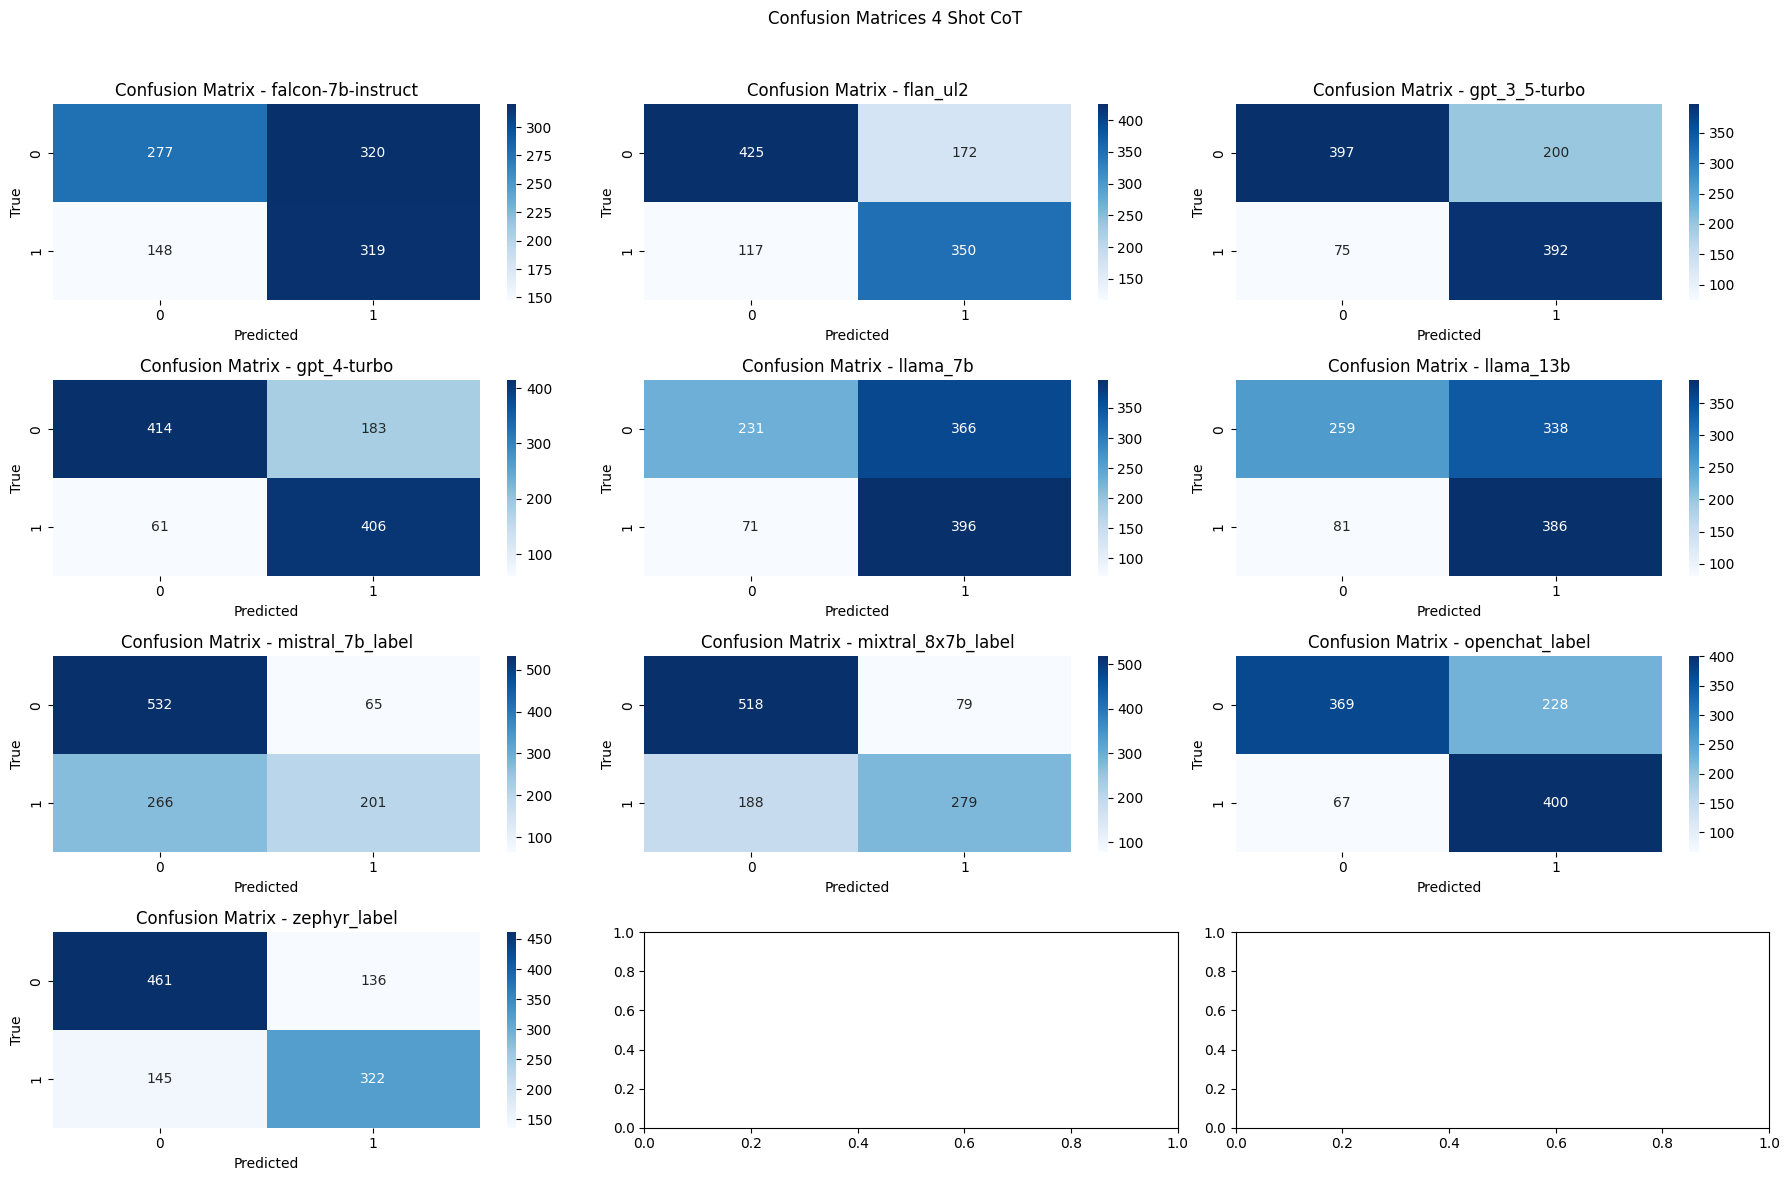

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('/home/sinix/PycharmProjects/Annomatic_Benchmark/4-shot-CoT/data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', 'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', 'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', 'gpt_3_5-turbo')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', 'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', 'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', 'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', 'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', 'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', 'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [55]:
from krippendorff import alpha
import numpy as np

runs = ['falcon_7b_label', 'flan_ul2_label',
       'gpt_3_5_label', 'gpt_4_label', 'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?'):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [56]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

Krippendorff's Alpha (all runs with invalid data): 0.43074097363706687
Krippendorff's Alpha (all runs without invalid data): 0.36741821128501484


In [57]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [58]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.2675758463501663
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.2564660194174757
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.17880642727679164
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.20862728543914721
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.13087501067037766
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.2177219652876673
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.25627109838495876
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.24068171707006003
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.3009815621696089
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.2575364903099129
Combination: ('falcon_7b_label', 'gpt_3

(0.616087234750966, ('gpt_3_5_label', 'gpt_4_label', 'openchat_label'))

In [59]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.41574536543390006
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.42786943379807896
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.27481437526796526
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.2884195882832947
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.18729695801058777
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.3577051867925647
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.43109367439951995
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.41088073470221154
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.4737848317428428
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.3559353949589712
Combination: ('falcon_7b_label', 'gpt_

(0.6265886133378524, ('gpt_3_5_label', 'openchat_label', 'zephyr_label'))

In [60]:
df_merge_all_runs.shape

(1064, 21)

In [61]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

(273, 21)